* Competition/Dataset : TMDB Box Office Prediction
* DATE : 2021/01/24

이 notebook은 다음의 notebook을 참고하여 공부한 것 입니다. 
* Link : https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation

# Part 0. 문제 정의 


**TMDB Box Office Prediction**은 과거에 상영된 영화 데이터를 이용하여 영화 수익을 예측해보는 대회이다. 

영화별 각 ID에 대한 수익 예측 값을 제출해야 한다. 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Part 1. Data loading and overview

## 1.1 Data set 불러오기

In [ ]:
train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')

In [ ]:
train.info()

In [ ]:
test.info()

train data와 test data를 살펴보면 총 21개의 features와 target value인 'revenue'가 있음을 알 수 있다. 

각각의 feature들이 의미하는 바는 다음과 같다. 

* 'id' : 각 영화의 고유 id 값
* 'belongs_to_collection' : TMDB ID, 이름, 영화 포스터 및 영화 URL이 JSON 형식으로 담겨져 있음
* 'budget' : 영화 예산, 달러로 표시. (단, 값을 알 수 없는 경우엔 0으로 표기)
* 'genres' : 장르 이름과 TMDB ID가 JSON 형식으로 담겨져 있음
* 'homepage' : 공식 홈페이지 URL
* 'imdb_id' : 영화의 IMDB ID(string 형식)
* 'original_language' : 두개의 문자로 표기된 영화 제작 언어
* 'original_title' : 영화의 원래 제목
* 'overview' : 영화에 대한 간단한 기술
* 'popularity' : 영화의 인기도
* 'poster_path' : 영화 포스터 주소
* 'production_companies' : 영화 제작사의 이름과 TMDB ID가 JSON 형식으로 저장
* 'production_countries' : 영화 제작 국가의 이름이 JSON 형식으로 저장
* 'release_date' : 영화 개봉일 (mm/dd/yy 형식)
* 'runtime' : 영화 상영시간
* 'status' : 개봉 여부
* 'tagline' : 영화의 tagline
* 'title' : 영화의 영어 제목
* 'Keywords' : TMDB ID와 모든 키워드가 JSON 형식으로 저장
* 'cast' : 모든 출연진의 TMDB ID, 이름, 캐릭터 이름, 성별이 JSON 형식으로 저장
* 'crew' : 제작과 관련된 인물들의 이름, TMDB ID, 프로필 주소
* 'revenue' : 영화 수익(달러 기준)


In [ ]:
train.head()

**딕셔너리** 형태로 담겨져 있는 feature가 존재함을 알 수 있다.

In [ ]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

train = text_to_dict(train)
test = text_to_dict(test)

앞서 대회의 dataset 설명을 보면 JSON 형식으로 저장된 feature들이 있다. 이것들을 읽어서 python 변수로 만들기 위해 **ast.literal_eval()** 을 사용한다. 

In [ ]:
train.shape, test.shape

Train set에 3000개의 samples이 있다. 이정도면 학습하기에 충분하다고 한다. 
또한 train set에선 feature의 개수가 23개인 반면 test set에선 22개인 이유는 우리의 예측 목표인 target variable의 유무 때문이다.

---
## Data Overview
## 1.2 belongs_to_collection

In [ ]:
for i, e in enumerate(train['belongs_to_collection'][:5]):
    print(i, e)

In [ ]:
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Missing value가 무려 2396개나 있는 것을 볼 수 있다. 

In [ ]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

`belongs_to_collection` 에 속해 있는 `name`과 collection의 유무에 관한 변수를 만든다. 다른 속성들은 이미지 주소값이기에 불필요하다. 

## 1.3 genres

In [ ]:
for i, e in enumerate(train['genres'][:5]):
    print(i, e)

`genres`가 1가지인 경우도 있지만 여러개인 경우도 존재한다. 그렇다면 각 sample 별로 `genres`가 총 몇 개인지 세어볼 필요가 있을 것 같다.

In [ ]:
print('Number of genres in films')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

`genres`가 2~3개인 경우가 가장 많고 특이한 점은 `genres`가 0개인 경우가 존재한다는 것이다. 이것을 결측값으로 봐야하는 지에 대한 고민이 든다. `genres`의 개수별로 통계를 내어보았으니 이젠 `genres`의 종류별로도 통계를 내볼 필요가 있을 것 같다. 

In [ ]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [ ]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                     width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

**Drama**, **Comedy**, **Thriller**이 가장 대중적인 `genres`인 것으로 보인다. 

In [ ]:
Counter([i for j in list_of_genres for i in j]).most_common()

In [ ]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

`genres` feature에 대해 one-hot-encoding을 적용하였다.

## 1.4 production_companies

In [ ]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

각 sample 별로 여러개의 `production_companies`가 존재하는 모습을 볼 수 있다. 따라서 몇개의 `production_companies`를 가지고 있는 지 나눠서 봐야할 것 같다.

In [ ]:
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

보통 영화당 1-2개의 `production_companies`를 가지고 있으며 때때로 3-4개의 `production_companies`를 가지고 있는 모습을 볼 수 있다.
 
드물지만 10개 이상의 `production_companies`를 가진 영화들도 있다. 이들은 어떤 영화들인 지 살펴보도록 하자.

In [ ]:
train[train['production_companies'].apply(lambda x: len(x) if x != {} else 0) > 11]

이제 어떤 `production_companies`이 빈번하게 나타나는 지를 살펴볼 차례이다. 

In [ ]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [ ]:
print(list_of_companies)

In [ ]:
Counter([i for j in list_of_companies for i in j]).most_common(30)

In [ ]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)

test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

## 1.5 production_countries

In [ ]:
for i, e in enumerate(train['production_countries'][:5]):
    print(i, e)

`production_countries`에서도 한 sample 당 여러 개의 항목을 가지고 있는 지 확인해보자.

In [ ]:
print('Number of production countries in films')
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

대부분 한 국가에서 제작되었지만 여러 국가들과 공동 제작한 영화들도 있다.
어떤 국가에서 주로 제작되었는지 살펴보자!

In [ ]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)

역시나 미국이 압도적으로 많다. 아까 `production_companies`에서 했던 작업을 그대로 해주도록 하자.

In [ ]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)

test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

    
train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

## 1.6 spoken_languages

In [ ]:
for i, e in enumerate(train['spoken_languages'][:100]):
    print(i, e)

In [ ]:
print('Number of spoken languages in films')
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

In [ ]:
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['iso_639_1'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)

아까와 비슷한 작업을 해주었고 역시나 영어가 가장 많이 사용되었음을 볼 수 있다.

In [ ]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

## 1.7 Keywords

In [ ]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i, e)

In [ ]:
print('Number of Keywords in films')
train['Keywords'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

`Keywords` 수의 분포가 거의 엇비슷한 것 같다. 숫자로 유의미한 차이를 가져올 수 있을 지는 잘 모르겠다. 다만 중요하다면 어떤 키워드가 나오는 지가 더 중요할 것 같다. 

In [ ]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
plt.figure(figsize = (16 ,12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None,  background_color='black', collocations=False,
                     width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis("off")
plt.show()

In [ ]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

## 1.8 cast

In [ ]:
for i, e in enumerate(train['cast'][:1]):
    print(i, e)

In [ ]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

등장 인물의 수도 중요할 수 있지만 그보다 훨씬 중요한 것은 '어떤 배우가 캐스팅 됐는 지'이다. 영화의 흥행에 많은 영향을 미칠 것이라고 생각이 든다. 배우별, 성별, 캐릭터에 따라 나눠볼 필요가 있을 것 같다.

### 1.8.1 name of casting

In [ ]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)


### 1.8.2 gender of casting

In [ ]:
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

* 0 : 명시되지 않은 값
* 1 : 여성
* 2 : 남성

남성이 가장 많이 캐스팅 되는 것으로 보이지만 명시되지 않은 값인 0을 지닌 sample이 상당히 많기 때문에 단정지을 순 없을 것 같다. 

### 1.8.3 character of casting

In [ ]:
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

In [ ]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test['cast_name_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

## 1.9 crew

In [ ]:
for i, en in enumerate(train['crew'][:1]):
    print(i, e[:10])

In [ ]:
print('Number of casted persons in films')
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

In [ ]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

In [ ]:
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

In [ ]:
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

In [ ]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

In [ ]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

# Part 2. Data Exploration

## 2.1 Missing value 확인

In [ ]:
train.isna().sum()

In [ ]:
test.isna().sum()

In [ ]:
train.isnull().sum() / train.shape[0]

In [52]:
test.isnull().sum() / test.shape[0]

id                            0.000000
budget                        0.000000
homepage                      0.677126
imdb_id                       0.000000
original_language             0.000000
                                ...   
departments_Directing         0.000000
departments_Editing           0.000000
departments_Visual Effects    0.000000
departments_Lighting          0.000000
departments_Actors            0.000000
Length: 232, dtype: float64

Test set에서도 'belongs_to_collection'에 약 80%, 'homepage'에 68%, 'tagline' 약 20%의 결측치가 존재한다.

## 2.2 Target value 확인

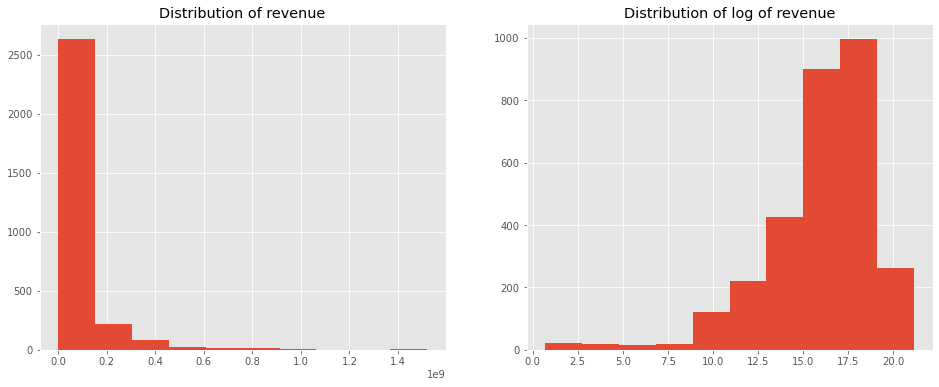

In [53]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

Target value인 'revenue'가 매우 skewed함으로 log를 씌워 관찰한다. 

In [54]:
train['log_revenue'] = np.log1p(train['revenue'])

## 2.3 Budget

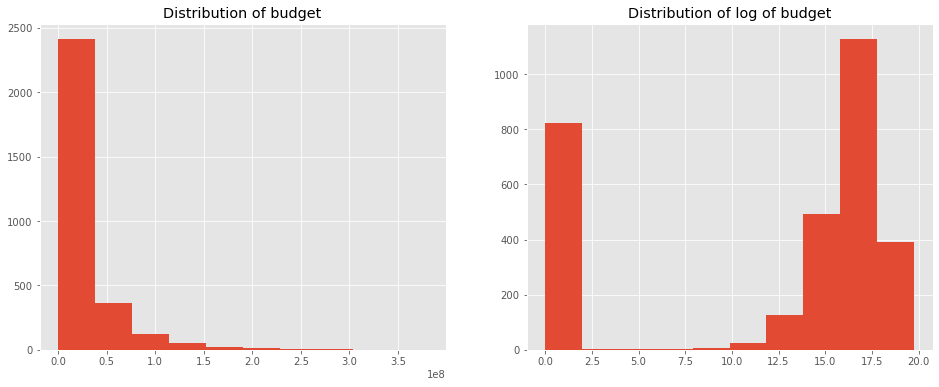

In [55]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

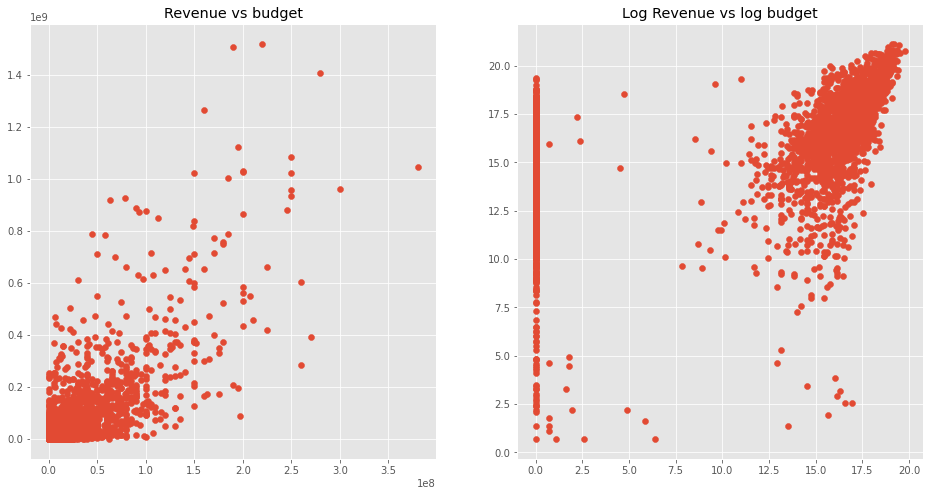

In [56]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget');

In [57]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

## 2.4 homepage

In [58]:
train['homepage'].value_counts().head()

http://www.transformersmovie.com/                      4
http://www.lordoftherings.net/                         2
http://www.thehobbit.com/                              2
http://disney.go.com/disneypictures/earthsea/#/home    1
http://www.sonypictures.com/movies/afewgoodmen/        1
Name: homepage, dtype: int64

대부분의 `homepage`들이 unique함을 알 수 있다. 따라서 이 feature는 딱히 필요가 없을 것 같다.

In [59]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

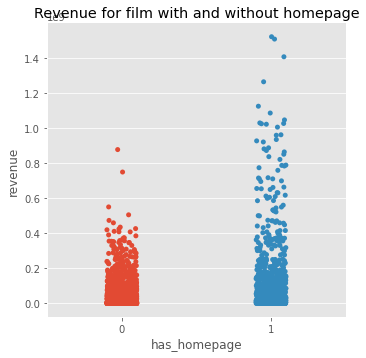

In [60]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for film with and without homepage');

다만 `homepage`의 유무를 기준으로 따져보면 `homepage`를 가지고 있는 쪽이 더 큰 `revenue`값을 가지는 것을 확인할 수 있다.

## 2.5 original_title

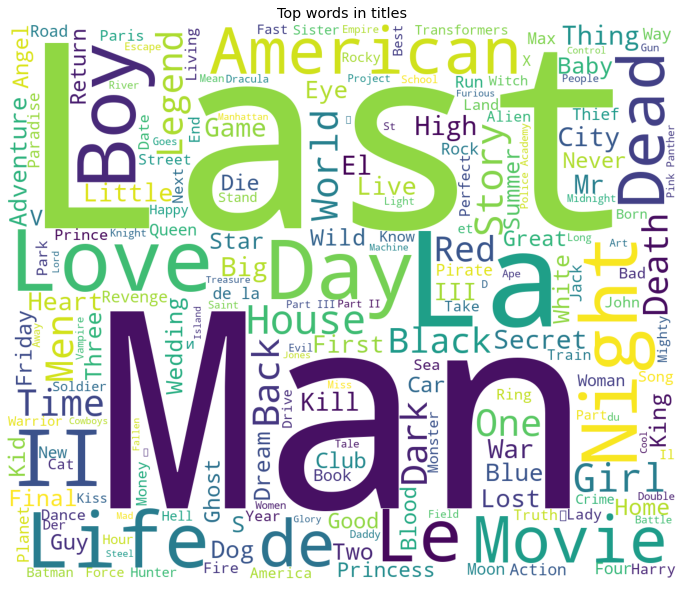

In [61]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

## 2.6 overview

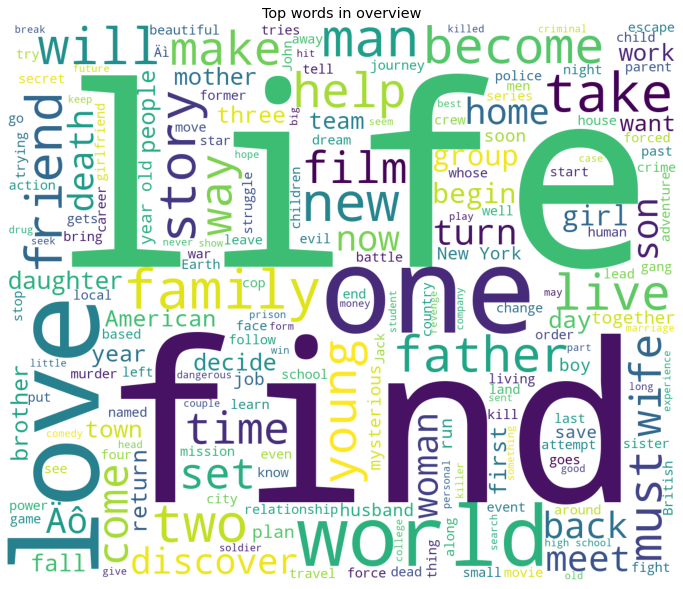

In [62]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

`revenue`에 가장 큰 영향을 주는 단어가 무엇인지 살펴보도록 하자. 

In [63]:
vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1,2),
            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')

In [64]:
print('Target value:', train['log_revenue'][1000])
eli5.show_prediction(linreg, doc=train['overview'].values[1000], vec=vectorizer)

Target value: 16.44583954907521


## 2.7 popularity

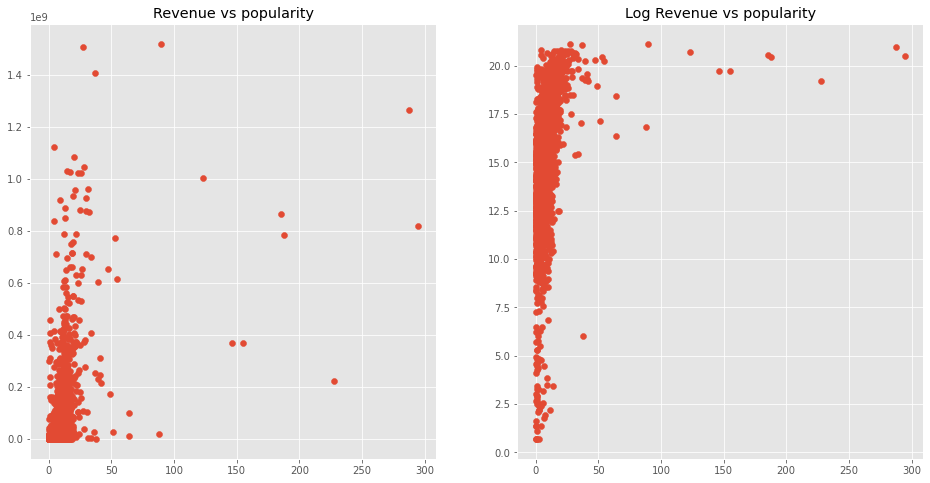

In [65]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity');
plt.subplot(1, 2, 2)
plt.scatter(train['popularity'], train['log_revenue'])
plt.title('Log Revenue vs popularity');

'popularity'와 'revenue'의 상관관계가 그리 뚜렷하지 않음을 볼 수 있다. 


## 2.8 release_date

In [66]:
test.loc[test['release_date'].isnull() == True, 'release_date'] = '01/01/98'

In [67]:
print(train['release_date'])

0        2/20/15
1         8/6/04
2       10/10/14
3         3/9/12
4         2/5/09
          ...   
2995     4/22/94
2996     3/28/13
2997    10/11/96
2998     1/16/04
2999     9/22/11
Name: release_date, Length: 3000, dtype: object


In [68]:
# 두 자리로 표현된 년도를 4자리로 바꾸는 함수

def fix_date(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

In [69]:
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

In [70]:
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
        
    return df

train = process_date(train)
test = process_date(test)

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [71]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = test['release_date_year'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Number of films per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [72]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [73]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

영화 작품의 수나 전체 `revenue`는 전반적으로 성장하는 모습을 보이고 있다. 하지만 평균`revenue`는 1970년대 후반과 같이 특정 성공한 작품이 존재했던 해에 큰 값을 보이는 모습을 볼 수 있다. 즉, 최신 작품이라고 해서 평균 `revenue`가 항상 높은 것은 아니라는 말이다. 다만 가장 최근에는 지금까지의 `revenue`를 뛰어넘는 모습을 볼 수 있다.

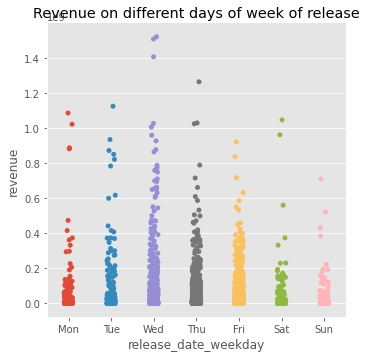

In [74]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels, fontsize=10)
plt.show()

수요일에 가장 큰 `revenue`를 보여준다.

## 2.9 runtime

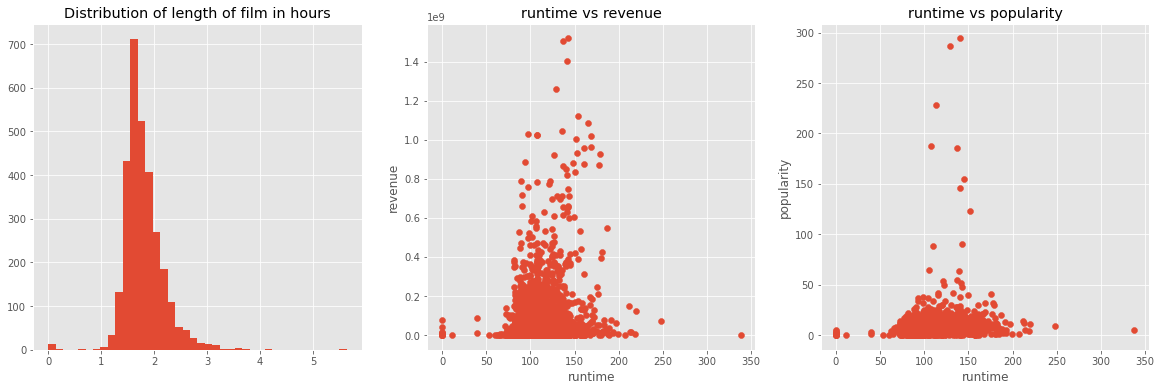

In [75]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime'].fillna(0)/60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'].fillna(0), train['revenue'])
plt.xlabel('runtime')
plt.ylabel('revenue')
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'].fillna(0), train['popularity'])
plt.xlabel('runtime')
plt.ylabel('popularity')
plt.title('runtime vs popularity');

보통 1.5-2시간의 `runtime`을 가지고 있는 영화가 `revenue`도 높고 `popularity`도 높은 편으로 나타난다.

## 2.10 status

In [76]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [77]:
test['status'].value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

train에선 4개, test에선 오직 7개만이 개봉되지 않은 상태이다. 따라서 이 feature는 필요하지 않을 것 같다.

## 2.11 tagline

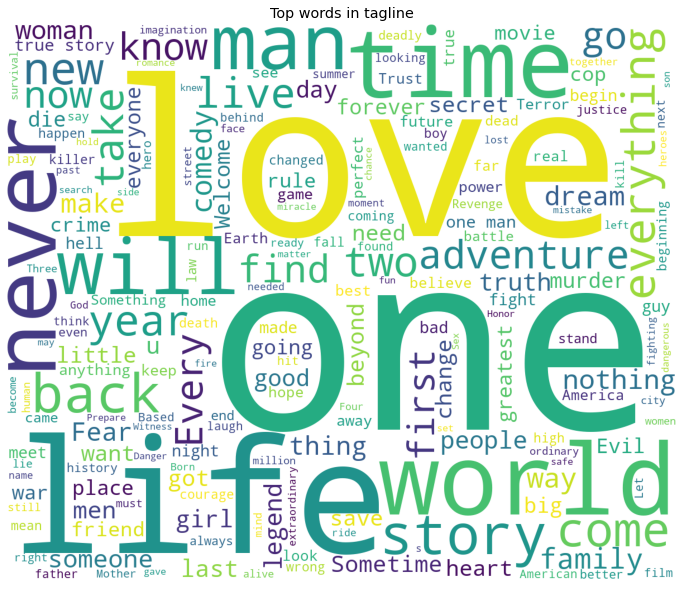

In [78]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

## 2.11 collections

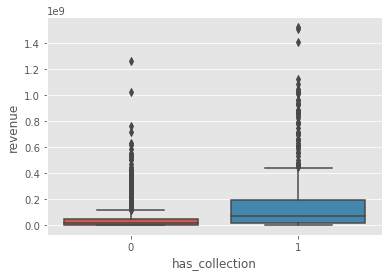

In [79]:
sns.boxplot(x='has_collection', y='revenue', data=train);

Collection을 가진 영화가 좀 더 높은 `revenue`를 가지고 있다. 아무래도 어벤져스나 마블 시리즈처럼 성공한 시리즈물일수록 거대한 팬층이 형성되고 그것이 다시 새 시리즈 작품의 이윤 창출에 많은 영향을 주기 때문이라고 생각된다.

## 2.11 genres

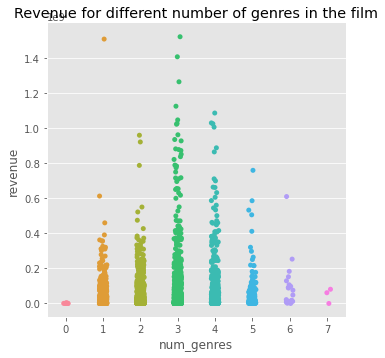

In [80]:
sns.catplot(x='num_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');

`genres`의 개수가 3개일 때 가장 높은 이윤을 보여주고 있다.

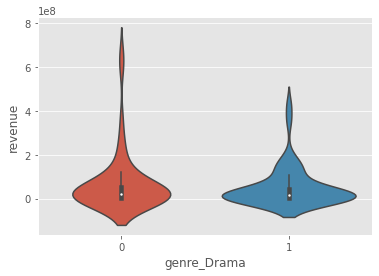

In [81]:
sns.violinplot(x='genre_Drama', y='revenue', data=train[:100]);

 이전에 살펴봤을 때 drama가 가장 많이 나오는 `genres`였기 때문에 drama를 `genres`로 가지고 있을 때의 `revenue`를 살펴보았다. 하지만 생각과는 다르게 drama가 아닐 때 더 높은 `revenue`를 가진 영화가 존재하였다.

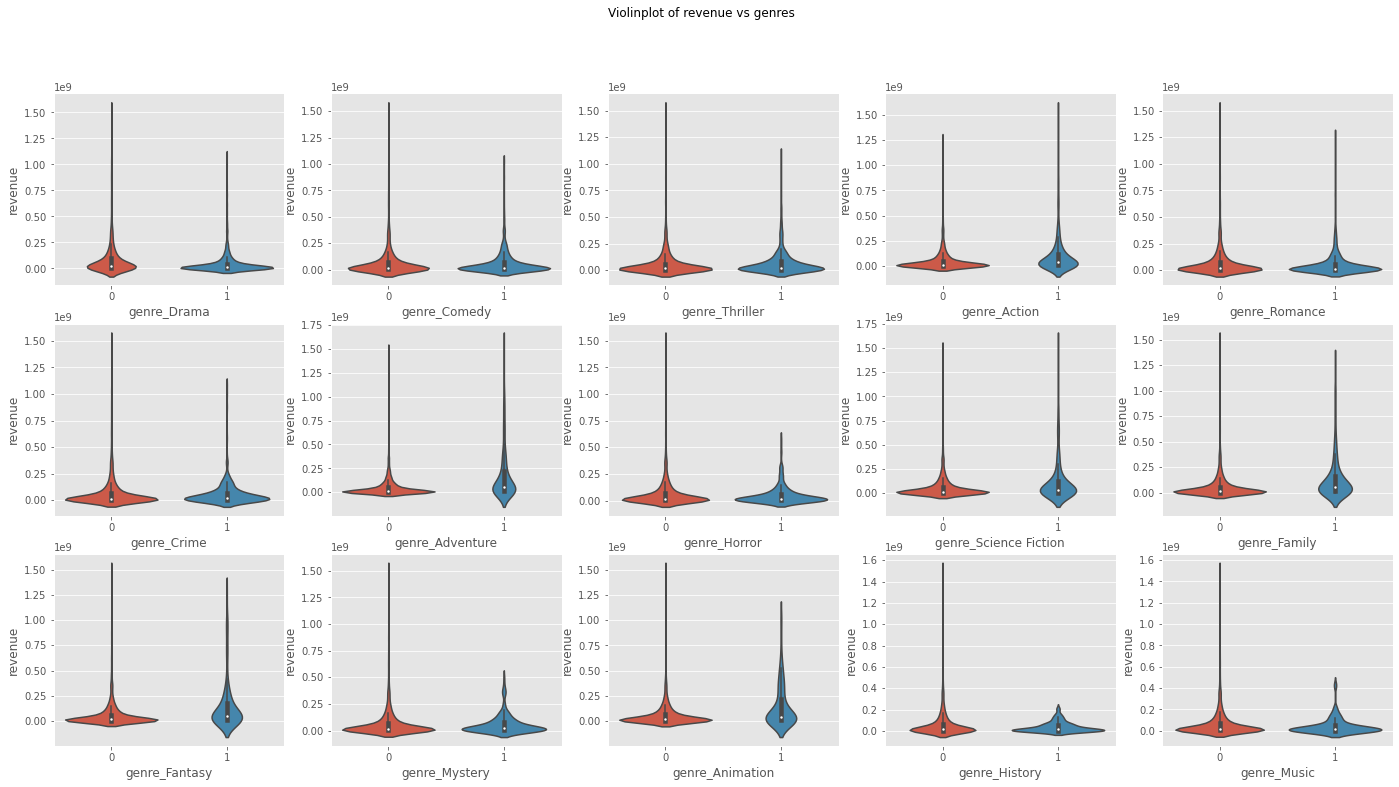

In [82]:
f, axes = plt.subplots(3, 5, figsize=(24, 12))
plt.suptitle('Violinplot of revenue vs genres')
for i, e in enumerate([col for col in train.columns if 'genre_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

몇몇 `genres`는 낮은 `revenue`를 보이고 몇몇 `genres`는 높은 것을 보아 `genres`도 나름 중요한 역할을 한다고 볼 수 있을 것 같다.

## 2.12 production companies

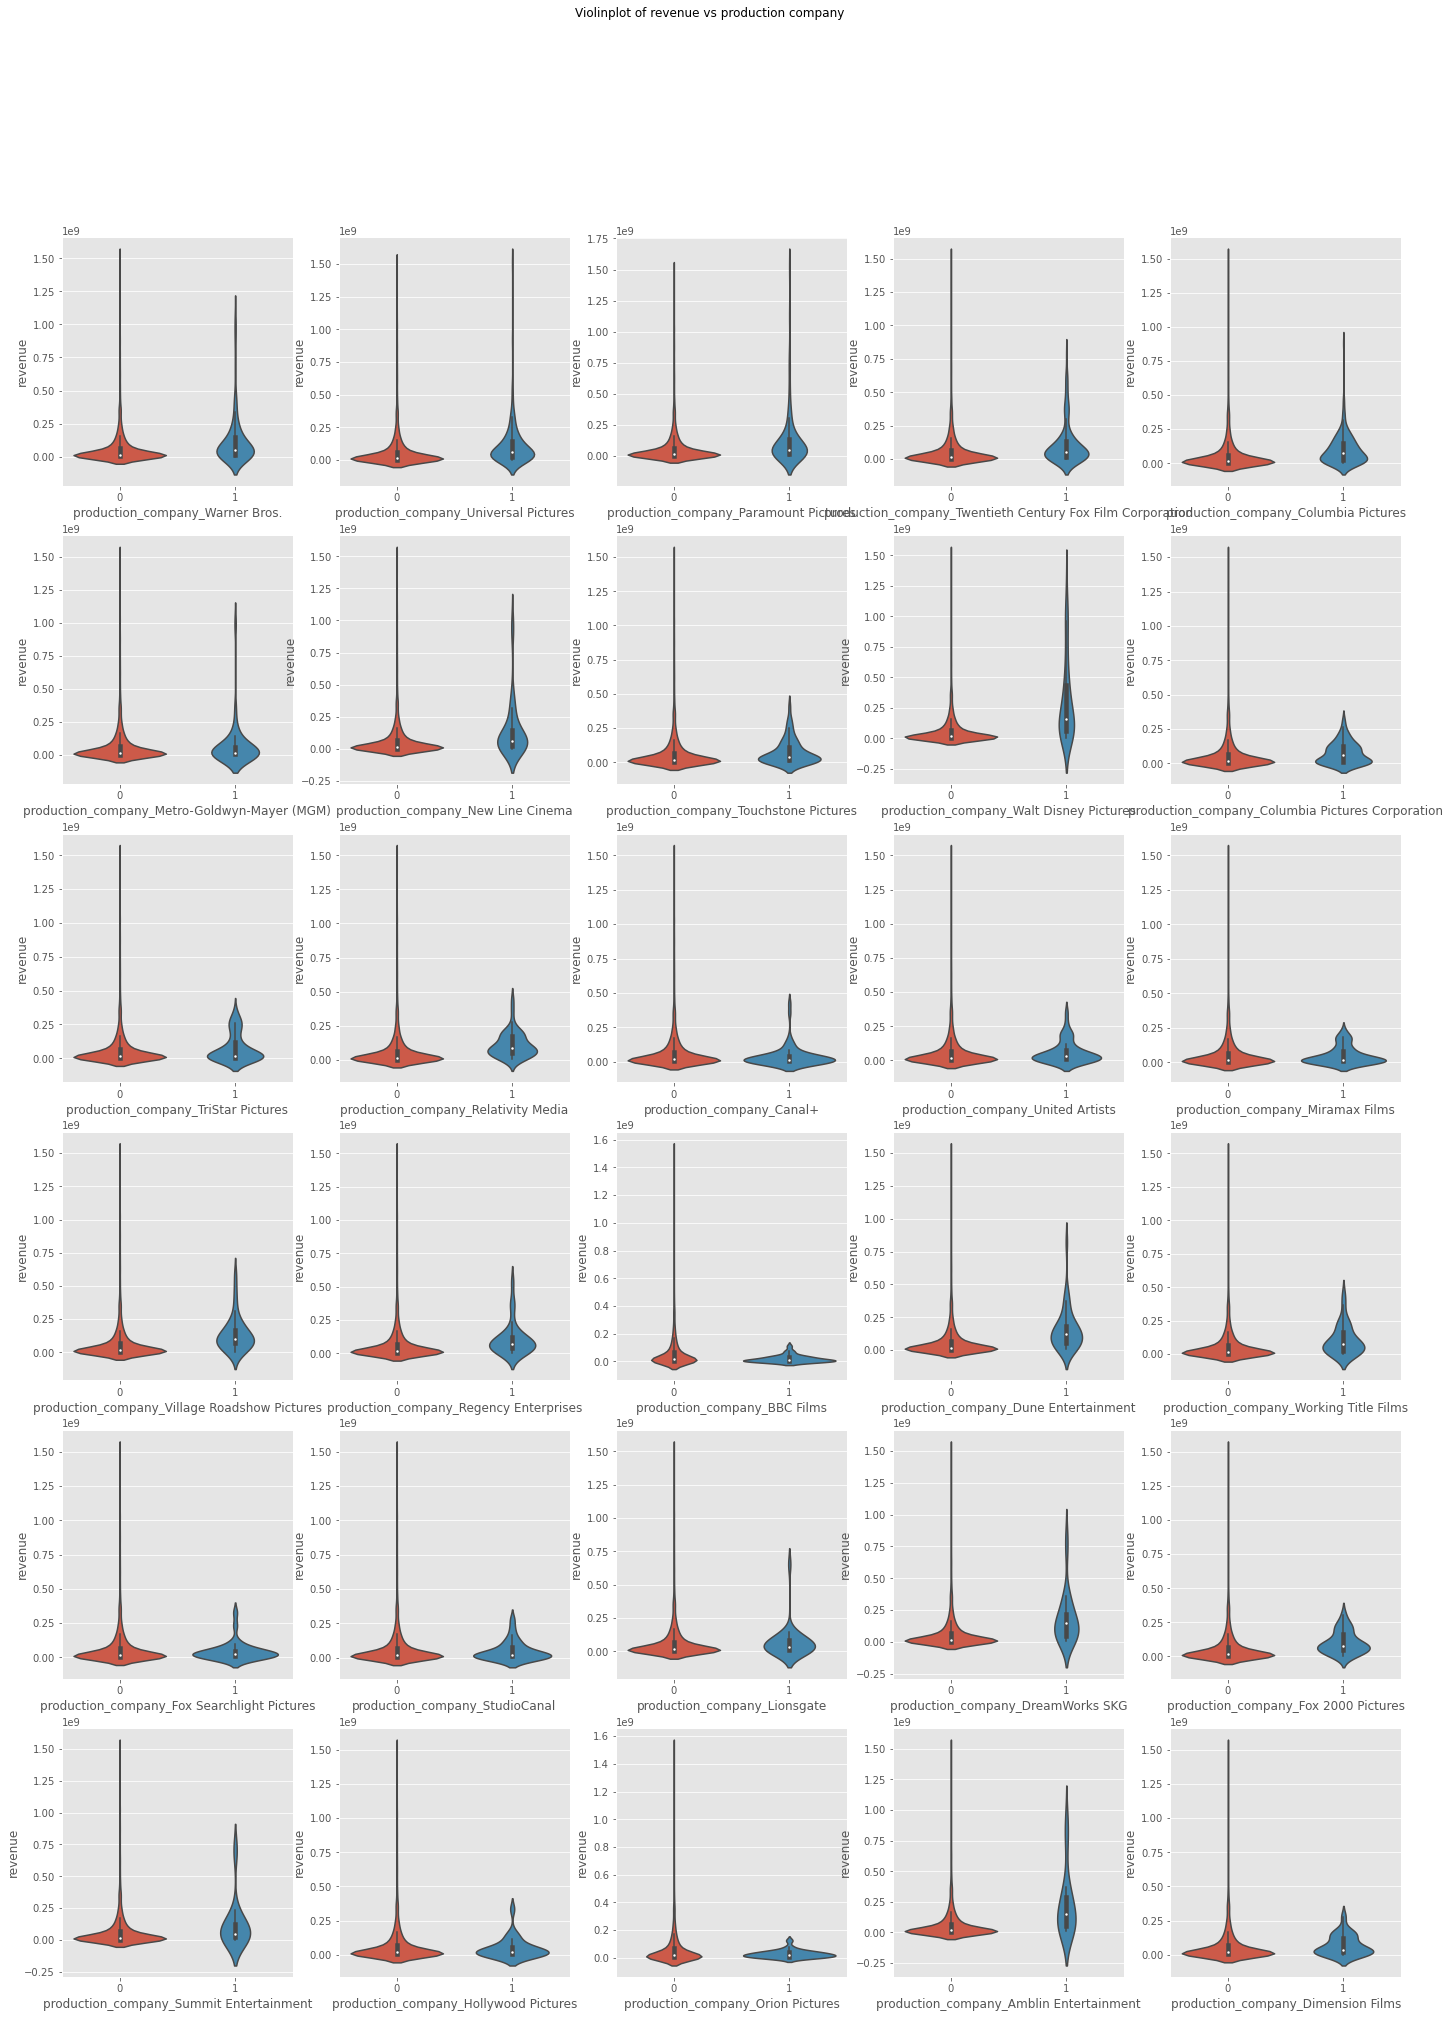

In [83]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production company')
for i, e in enumerate([col for col in train.columns if 'production_company' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5])

소수의 회사들만이 다른 회사들보다 높은 `revenue`를 보이고 있다. 

## 2.13 production countries

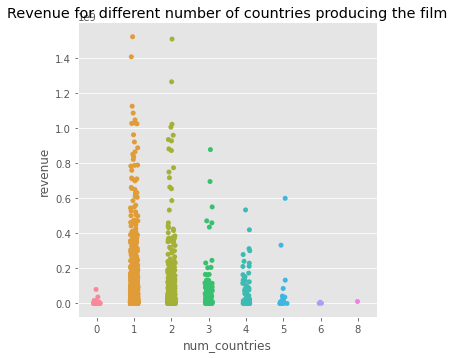

In [84]:
sns.catplot(x='num_countries', y='revenue', data=train)
plt.title('Revenue for different number of countries producing the film');

`production_countries`의 개수가 1-2개일 때 가장 높은 `revenue`를 보여주지만 이는 대부분의 영화들이 1-2개의 `production_countries`를 가지고 있기 때문에 그렇다고 볼 수 있을 것 같다. 따라서 `production_countries`의 수는 그다지 중요하지 않을 것 같다.

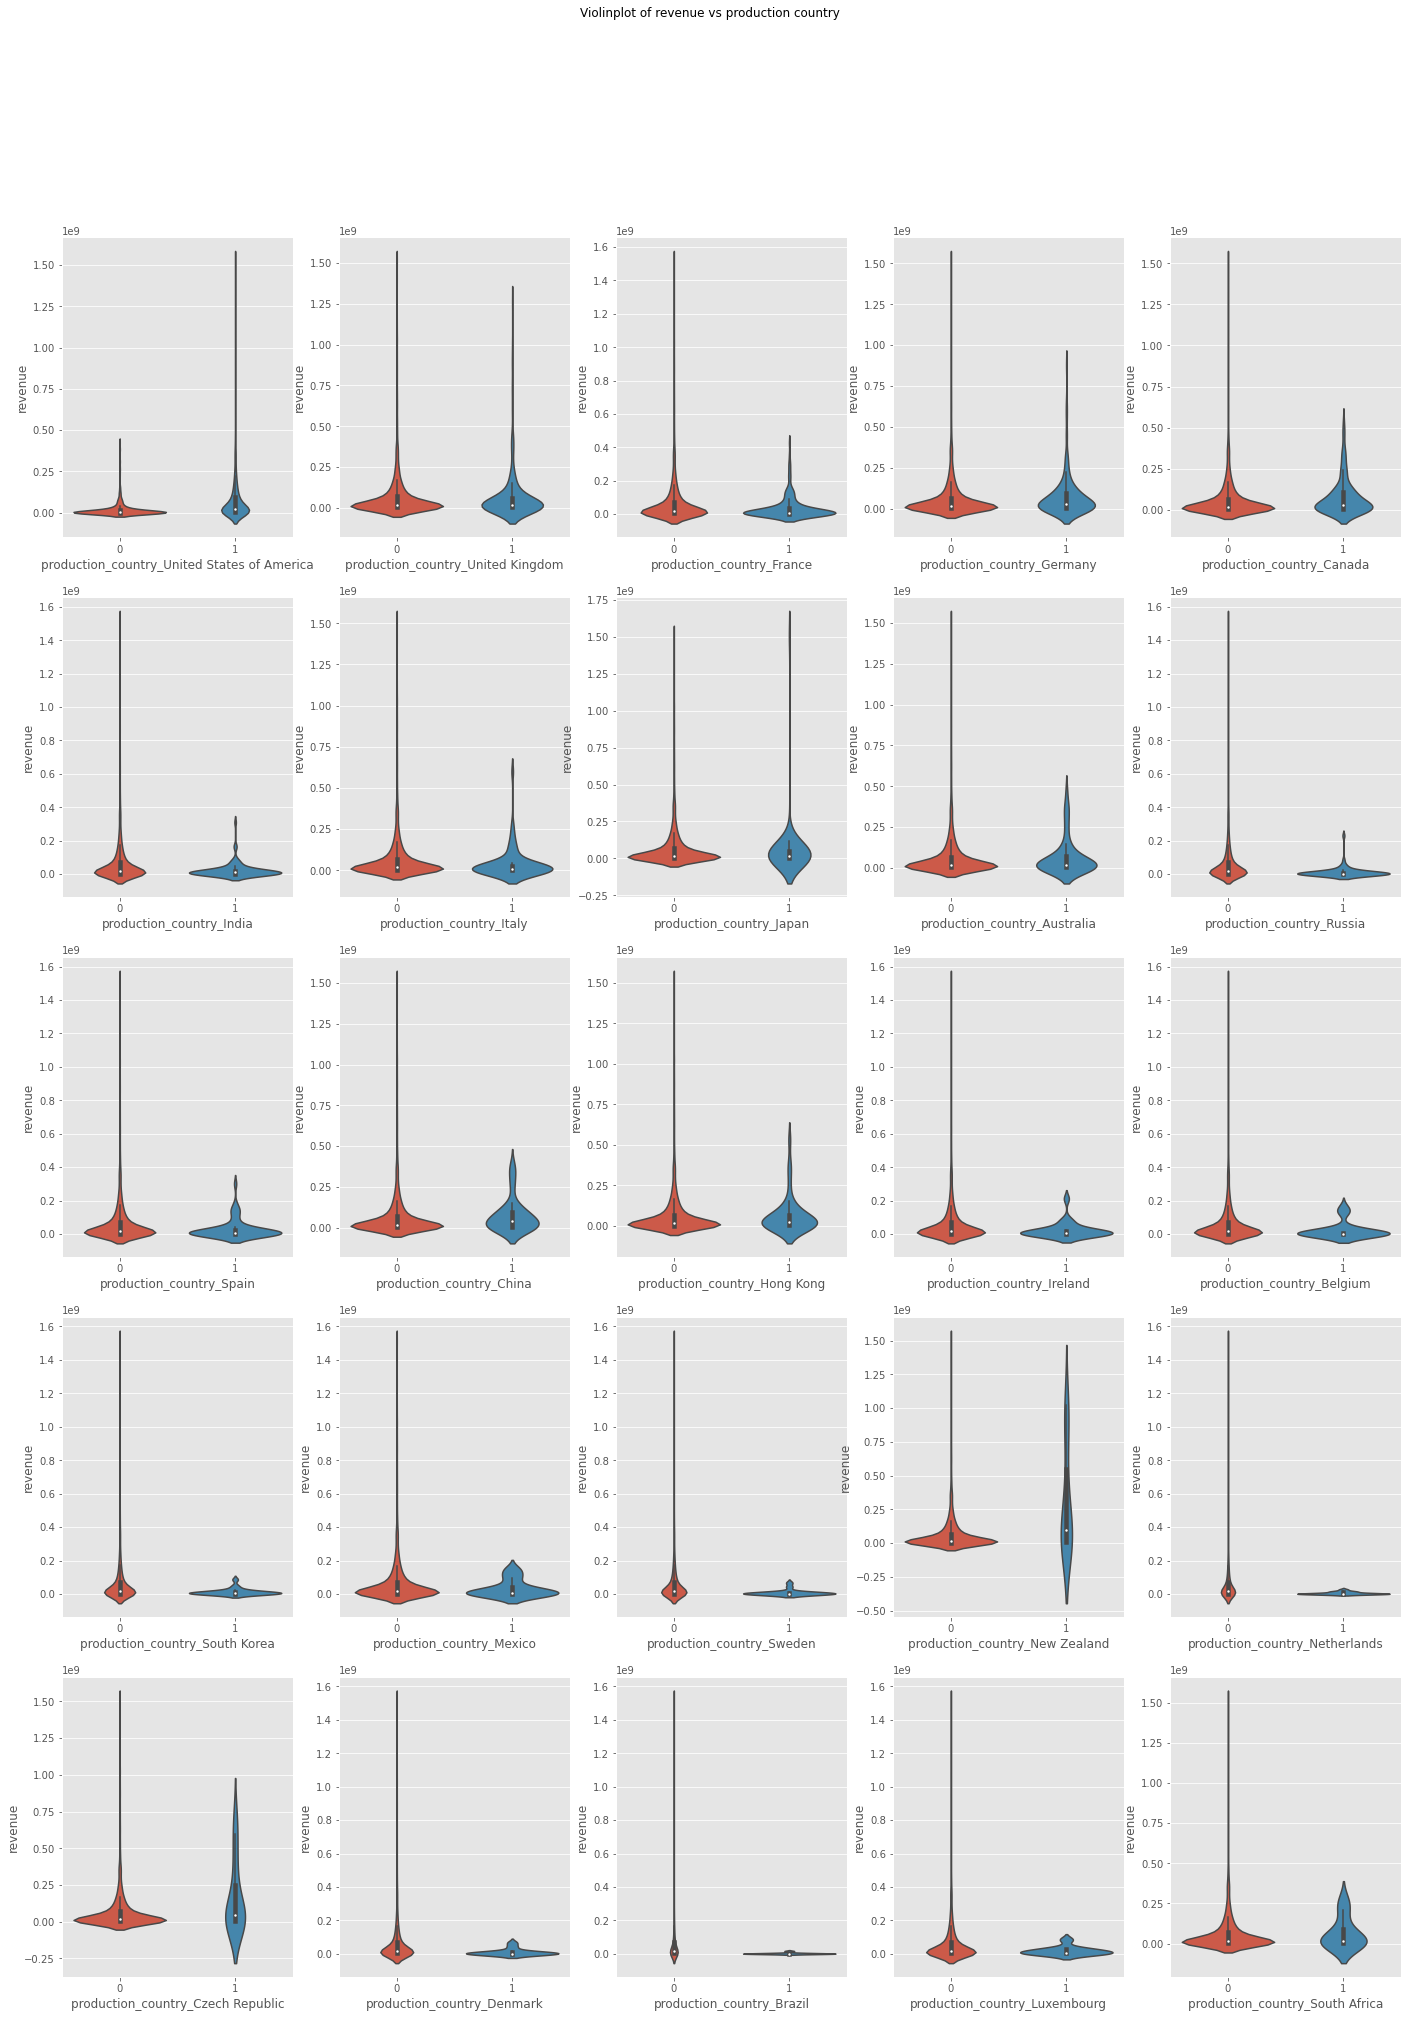

In [85]:
f, axes = plt.subplots(5, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs production country')
for i, e in enumerate([col for col in train.columns if 'production_country' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

미국과 일본정도만 다른 나라에 비해서 높은 `revenue`를 보여주고 있다.

## 2.14 cast

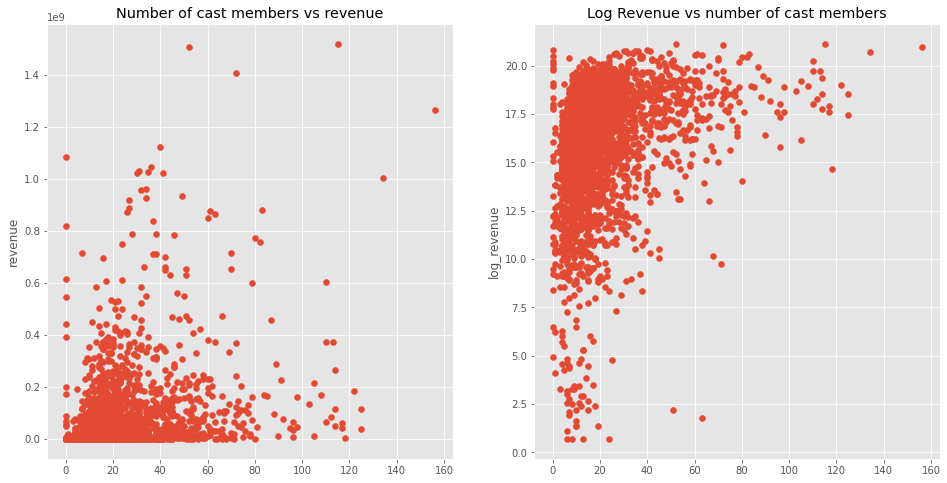

In [86]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_cast'], train['revenue'])
plt.title('Number of cast members vs revenue');
plt.ylabel('revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_cast'], train['log_revenue'])
plt.title('Log Revenue vs number of cast members');
plt.ylabel('log_revenue');

`cast` member의 수와 `revenue`는 어느정도 비례관계에 있지만 `cast` member의 수가 대부분 0-40에 몰려있다는 점은 생각해봐야 할 것 같다.

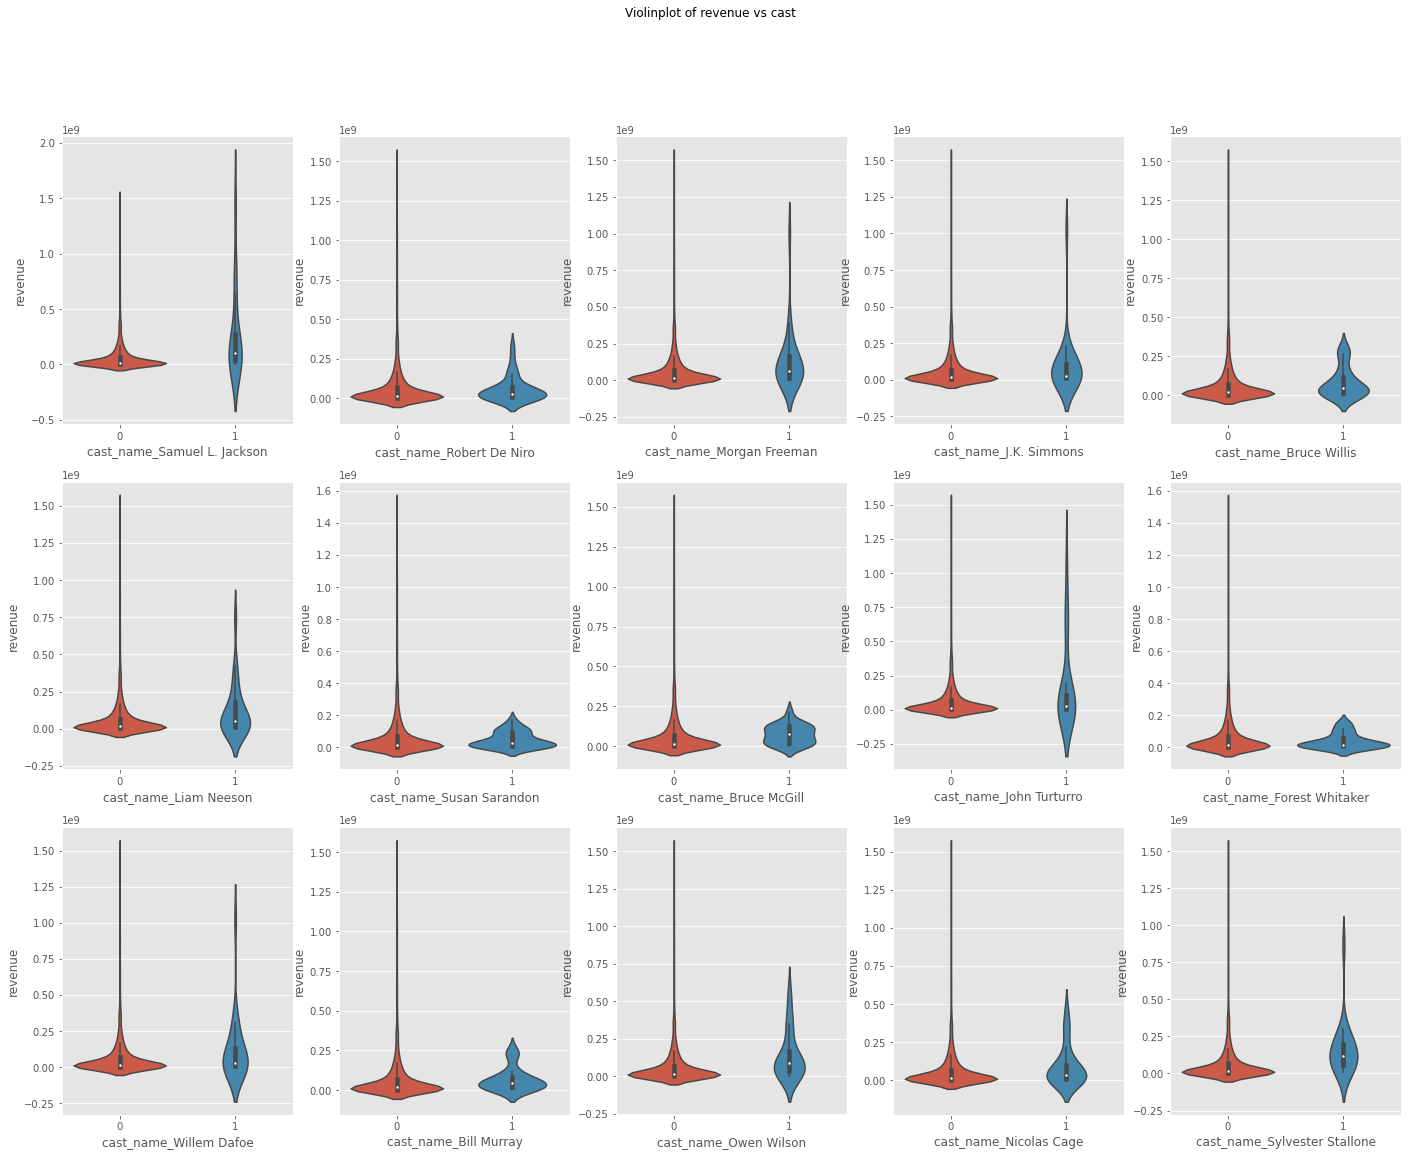

In [87]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_name' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

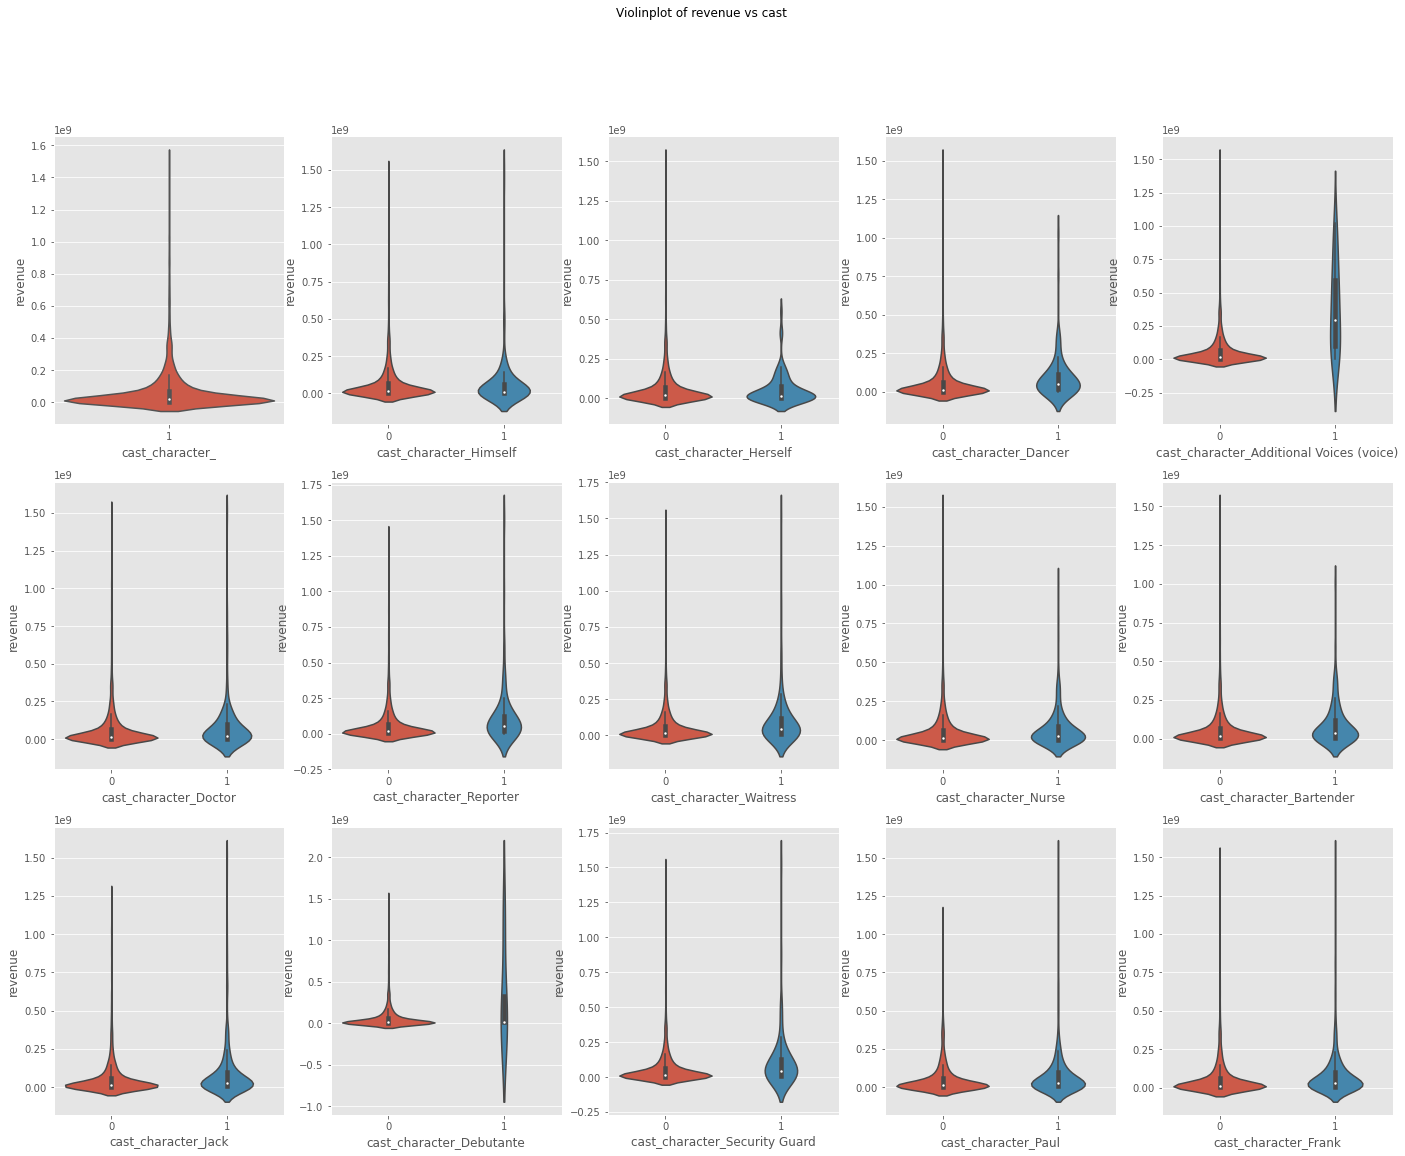

In [88]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

## 2.15 keyword

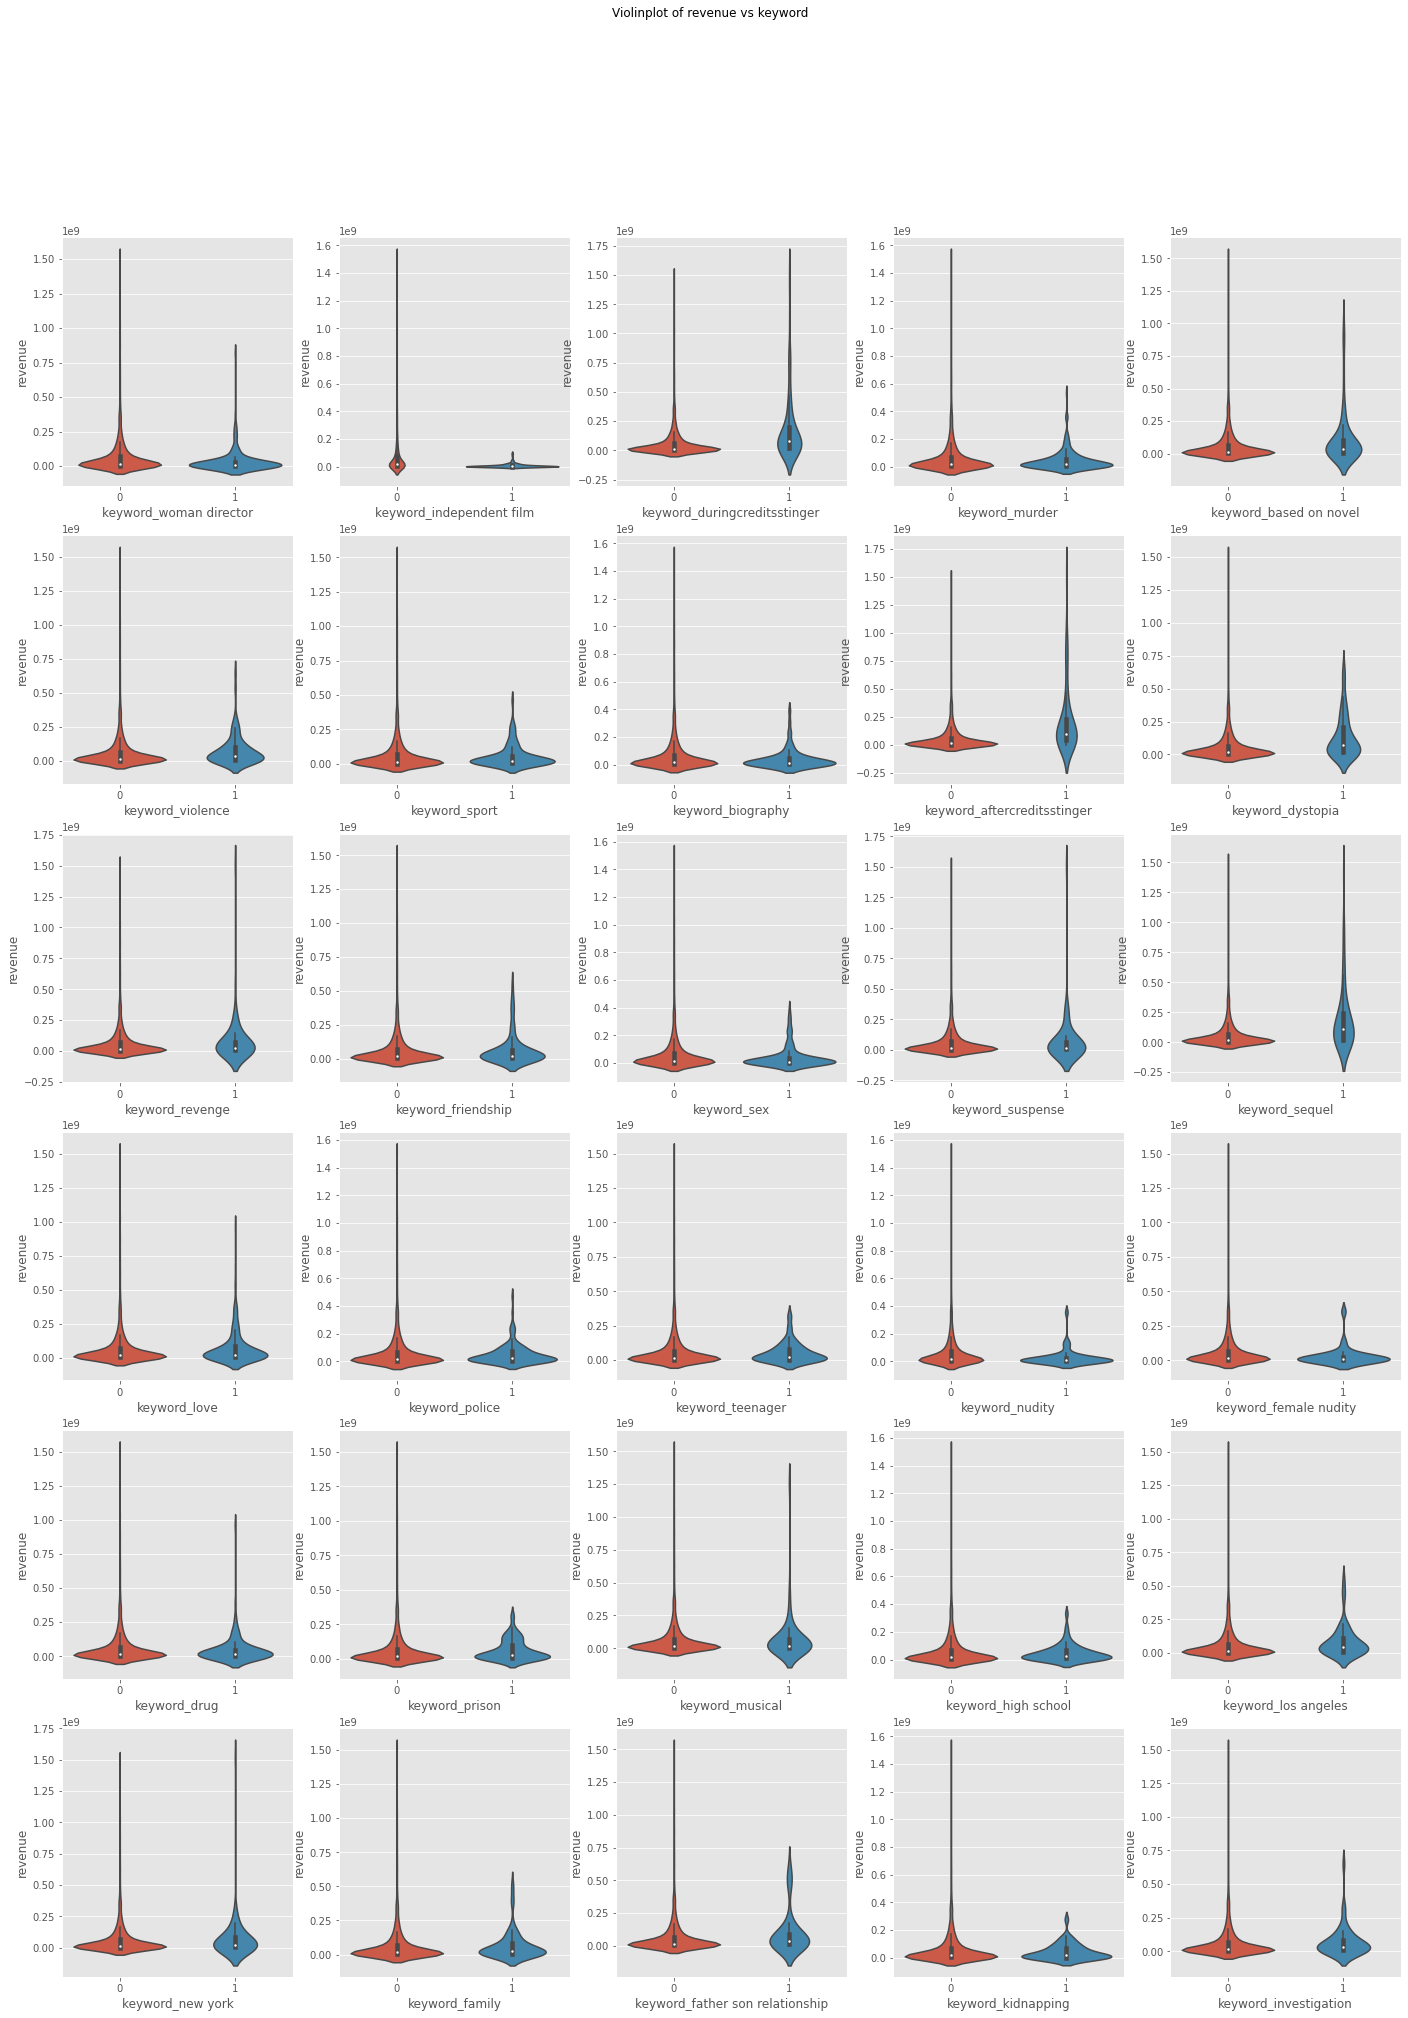

In [89]:
f, axes = plt.subplots(6, 5, figsize=(24, 32))
plt.suptitle('Violinplot of revenue vs keyword')
for i, e in enumerate([col for col in train.columns if 'keyword_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

# 2.16 crew

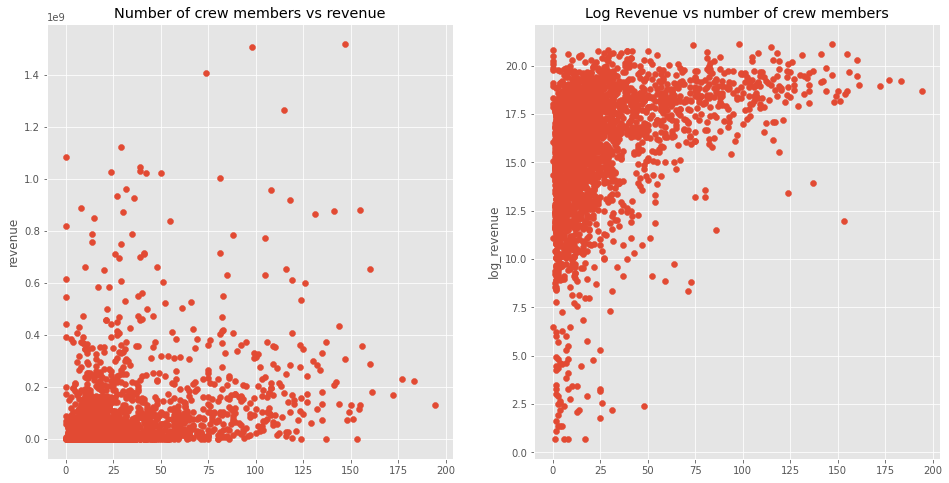

In [90]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_crew'], train['revenue'])
plt.title('Number of crew members vs revenue');
plt.ylabel('revenue');
plt.subplot(1, 2, 2)
plt.scatter(train['num_crew'], train['log_revenue'])
plt.title('Log Revenue vs number of crew members');
plt.ylabel('log_revenue');

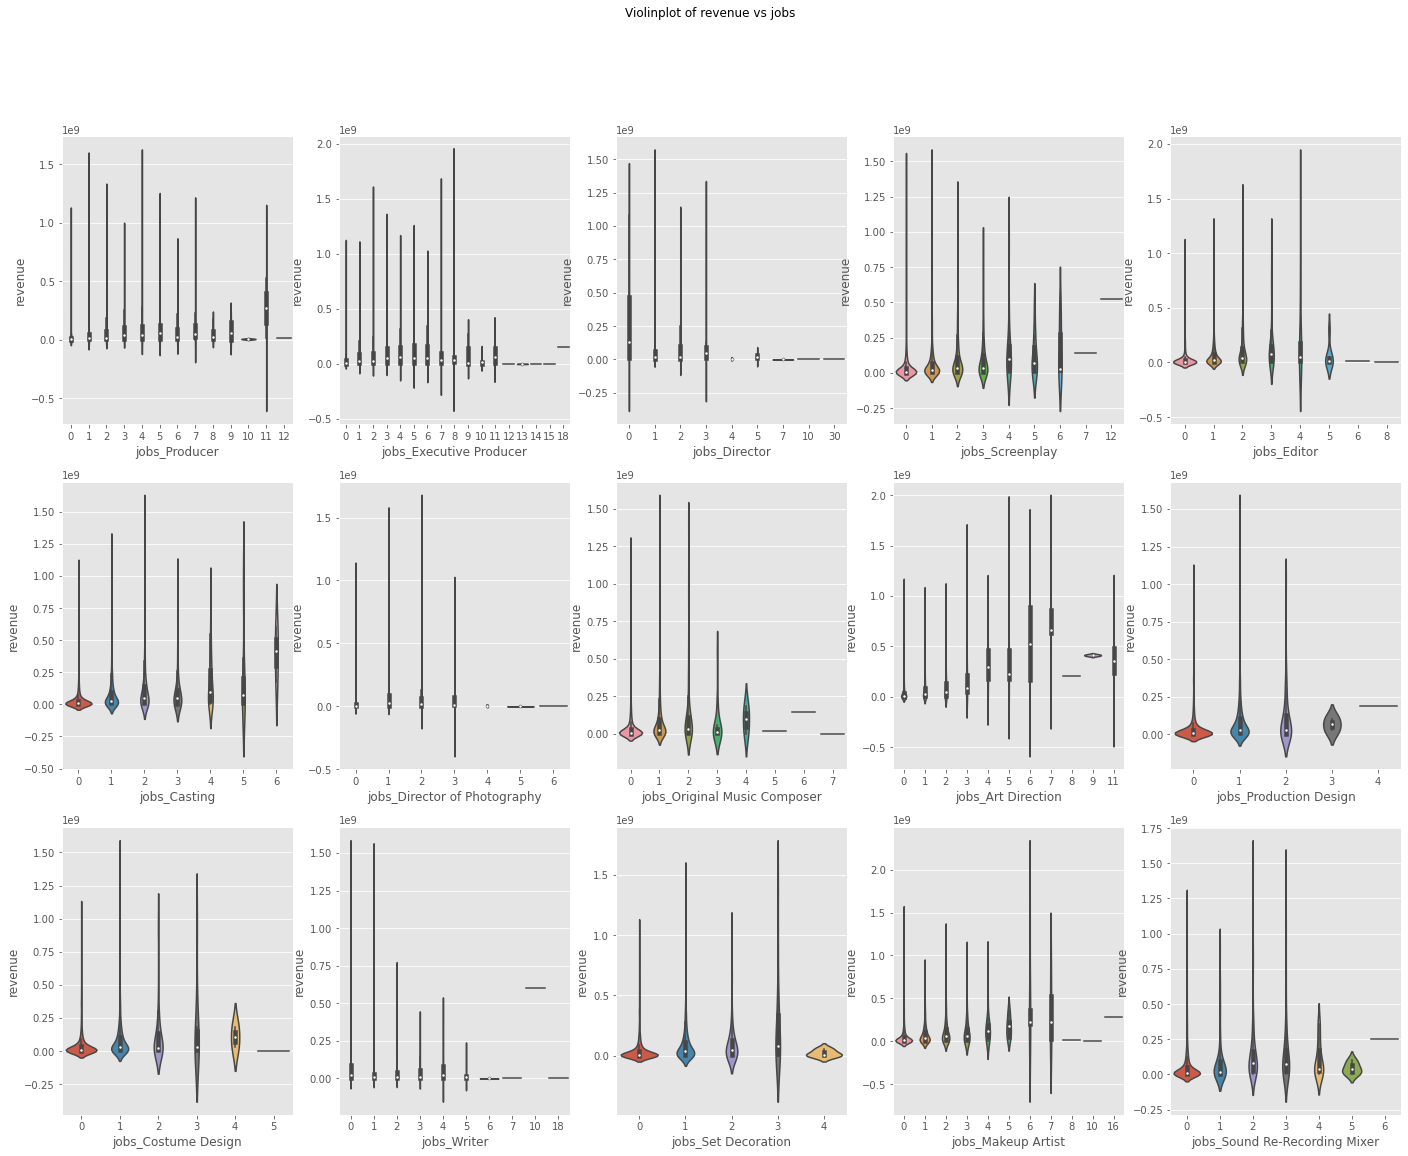

In [91]:
f, axes = plt.subplots(3, 5, figsize=(24, 18))
plt.suptitle('Violinplot of revenue vs jobs')
for i, e in enumerate([col for col in train.columns if 'jobs_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

(뭔가 한눈에 잘 들어오지 않는다. 나중에 좀 표현 방식을 바꿔야겠다..)

# Part3. Modelling and feature generation

In [92]:
train = train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status', 'log_revenue'], axis=1)
test = test.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

사용하지 않을 feature들을 제거한다.

In [93]:
for col in train.columns:
    if train[col].nunique() == 1:
        print(col)
        train = train.drop([col], axis=1)
        test = test.drop([col], axis=1)

cast_character_


In [94]:
for col in ['original_language', 'collection_name', 'all_genres']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))

LabelEncoder를 통해서 categorical variable을 수치화시킨다. 

In [95]:
train_texts = train[['title', 'tagline', 'overview', 'original_title']]
test_texts = test[['title', 'tagline', 'overview', 'original_title']]

In [96]:
for col in ['title', 'tagline', 'overview', 'original_title']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    train = train.drop(col, axis=1)
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test = test.drop(col, axis=1)

Text features를 각각의 갯수와 단어별로 나누어 저장한다.

In [97]:
# data fixes from https://www.kaggle.com/somang1418/happy-valentines-day-and-keep-kaggling-3
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

In [98]:
X = train.drop(['id', 'revenue'], axis=1)
y = np.log1p(train['revenue'])
X_test = test.drop(['id'], axis=1)

In [99]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [100]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.30966	valid_1's rmse: 1.77954
Early stopping, best iteration is:
[1298]	training's rmse: 1.20769	valid_1's rmse: 1.77655


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', feature_fraction=0.9, lambda_l1=0.2,
              learning_rate=0.01, max_depth=5, metric='rmse',
              min_data_in_leaf=20, n_estimators=20000, nthread=4, num_leaves=30,
              objective='regression', verbosity=-1)

In [101]:
eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.4361,budget
0.1137,popularity
0.0660,release_date_year
0.0414,log_budget
0.0276,runtime
0.0179,all_genres
0.0177,genders_2_crew
0.0139,release_date_day
0.0127,genders_1_cast
0.0122,collection_name


In [102]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [103]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_squared_error(y_valid, y_pred_valid)
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Tue Feb  2 13:27:25 2021
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.1777	valid_1's rmse: 1.83537
Early stopping, best iteration is:
[1022]	training's rmse: 1.17073	valid_1's rmse: 1.83455
Fold 1 started at Tue Feb  2 13:27:27 2021
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.21387	valid_1's rmse: 1.82245
Early stopping, best iteration is:
[997]	training's rmse: 1.21542	valid_1's rmse: 1.82214
Fold 2 started at Tue Feb  2 13:27:30 2021
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.22351	valid_1's rmse: 1.69822
[2000]	training's rmse: 0.916279	valid_1's rmse: 1.66665
Early stopping, best iteration is:
[2564]	training's rmse: 0.789251	valid_1's rmse: 1.66068
Fold 3 started at Tue Feb  2 13:27:34 2021
Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 1.20348	valid_1's rmse: 1.8559
[2000]	training's rmse: 0.88

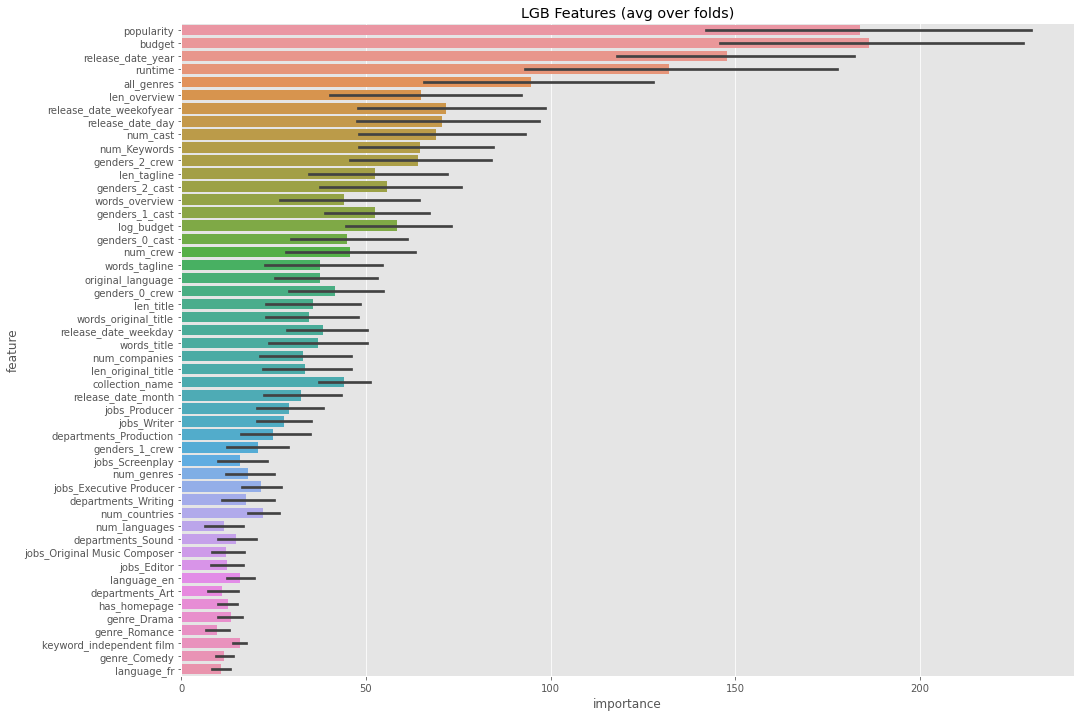

In [104]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb', plot_feature_importance=True)

## 3.2 OOF features based on texts

In [105]:
for col in train_texts.columns:
    vectorizer = TfidfVectorizer(
                sublinear_tf=True,
                analyzer='word',
                token_pattern=r'\w{1,}',
                ngram_range=(1, 2),
                min_df=10
    )
    vectorizer.fit(list(train_texts[col].fillna('')) + list(test_texts[col].fillna('')))
    train_col_text = vectorizer.transform(train_texts[col].fillna(''))
    test_col_text = vectorizer.transform(test_texts[col].fillna(''))
    model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
    oof_text, prediction_text = train_model(train_col_text, test_col_text, y, params=None, model_type='sklearn', model=model)
    
    X[col + '_oof'] = oof_text
    X_test[col + '_oof'] = prediction_text

Fold 0 started at Tue Feb  2 13:27:59 2021
Fold 1 started at Tue Feb  2 13:27:59 2021
Fold 2 started at Tue Feb  2 13:28:00 2021
Fold 3 started at Tue Feb  2 13:28:00 2021
Fold 4 started at Tue Feb  2 13:28:00 2021
Fold 5 started at Tue Feb  2 13:28:01 2021
Fold 6 started at Tue Feb  2 13:28:01 2021
Fold 7 started at Tue Feb  2 13:28:02 2021
Fold 8 started at Tue Feb  2 13:28:02 2021
Fold 9 started at Tue Feb  2 13:28:02 2021
CV mean score: 2.9692, std: 0.2116.
Fold 0 started at Tue Feb  2 13:28:03 2021
Fold 1 started at Tue Feb  2 13:28:04 2021
Fold 2 started at Tue Feb  2 13:28:04 2021
Fold 3 started at Tue Feb  2 13:28:05 2021
Fold 4 started at Tue Feb  2 13:28:05 2021
Fold 5 started at Tue Feb  2 13:28:06 2021
Fold 6 started at Tue Feb  2 13:28:06 2021
Fold 7 started at Tue Feb  2 13:28:07 2021
Fold 8 started at Tue Feb  2 13:28:07 2021
Fold 9 started at Tue Feb  2 13:28:08 2021
CV mean score: 2.8814, std: 0.1759.
Fold 0 started at Tue Feb  2 13:28:11 2021
Fold 1 started at Tue Feb